In [255]:
# Start loading libraries

#! pip install yfinance

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#! pip install pmdarima
import pmdarima as pm
from pmdarima import model_selection

import scipy
import statsmodels.api as sm
import datetime
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
from arch.unitroot import KPSS

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
#from statsmodels.graphics.tsaplots import plot_acf

from scipy.optimize import curve_fit

#from matplotlib.ticker import NullFormatter
#import yfinance as yf
#import warnings; warnings.simplefilter('ignore')
#%matplotlib inline

In [2]:
xls_file = pd.ExcelFile("Data_monthly_final.xlsx") # Read Excel
df1=xls_file.parse("SBO") # Read the first sheet (Portfolio holdings)

#df1["Timestamp"] = df1["Date"].astype('datetime64[ns]') # Convert column to date format
df1 = df1.set_index(['Timestamp']) # use first column as index

#df1.to_excel("values.xlsx")  #print to excel


df1.describe()

,BOc1,BOc3,BOc6,BOc9,BOc12,BOc1_usd_mt,BOc3_usd_mt,BOc6_usd_mt,BOc9_usd_mt,BOc12_usd_mt
count,507.000000,507.000000,507.000000,500.000000,297.000000,507.000000,507.000000,507.000000,507.000000,507.000000
mean,29.687909,29.850671,29.951085,30.102980,34.933199,654.506476,658.094750,660.308505,654.494301,451.150224
std,13.128232,12.679125,12.354391,12.152939,13.252824,289.428033,279.526899,272.367752,277.128978,440.609379
min,13.560000,14.230000,14.900000,15.220000,17.070000,298.946879,313.717853,328.488827,0.000000,0.000000
25%,20.770000,21.255000,21.430000,21.630000,23.900000,457.900197,468.592619,472.450709,472.671171,0.000000
50%,26.090000,25.920000,25.820000,25.740000,32.750000,575.186141,571.438282,569.233659,565.485799,442.026912
75%,33.505000,33.670000,34.075000,34.160000,42.520000,738.658936,742.296564,751.225287,749.682051,752.217368
max,89.170000,79.950000,75.340000,72.610000,70.430000,1965.862329,1762.596089,1660.962968,1600.776760,1552.715979


In [180]:
curve = df1[["BOc1","BOc3","BOc6","BOc9","BOc12"]]
curve.describe()

,BOc1,BOc3,BOc6,BOc9,BOc12
count,507.000000,507.000000,507.000000,500.000000,297.000000
mean,29.687909,29.850671,29.951085,30.102980,34.933199
std,13.128232,12.679125,12.354391,12.152939,13.252824
min,13.560000,14.230000,14.900000,15.220000,17.070000
25%,20.770000,21.255000,21.430000,21.630000,23.900000
50%,26.090000,25.920000,25.820000,25.740000,32.750000
75%,33.505000,33.670000,34.075000,34.160000,42.520000
max,89.170000,79.950000,75.340000,72.610000,70.430000


In [181]:
#tidy_curve = curve.melt(var_name='RIC', value_name='Price')
tidy_curve = pd.DataFrame(curve.stack())
tidy_curve

0
Timestamp              
1980-10-31 BOc1   26.72
           BOc3   27.87
           BOc6   28.45
           BOc9   26.75
1980-11-30 BOc1   28.33
...                 ...
2022-12-31 BOc1   65.93
           BOc3   63.77
           BOc6   61.86
           BOc9   60.62
           BOc12  59.69

[2318 rows x 1 columns]

In [186]:
month = tidy_curve.index.get_level_values(0).month.values
#year = [my_str.split("-")[0] for my_str in year]
tidy_curve["month"] = month
tidy_curve


0  month  expiry
Timestamp                             
1980-10-31 BOc1   26.72     10       2
           BOc3   27.87     10       5
           BOc6   28.45     10      10
           BOc9   26.75     10      14
1980-11-30 BOc1   28.33     11       1
...                 ...    ...     ...
2022-12-31 BOc1   65.93     12       1
           BOc3   63.77     12       5
           BOc6   61.86     12       9
           BOc9   60.62     12      13
           BOc12  59.69     12      17

[2318 rows x 3 columns]

In [187]:
future = tidy_curve.index.get_level_values(1).values
c = [my_str.split("c")[1] for my_str in future]
tidy_curve["c"] = c

In [188]:
tidy_curve[["month"]] = tidy_curve[["month"]].apply(pd.to_numeric)
tidy_curve[["c"]] = tidy_curve[["c"]].apply(pd.to_numeric)
tidy_curve

0  month  expiry   c
Timestamp                                 
1980-10-31 BOc1   26.72     10       2   1
           BOc3   27.87     10       5   3
           BOc6   28.45     10      10   6
           BOc9   26.75     10      14   9
1980-11-30 BOc1   28.33     11       1   1
...                 ...    ...     ...  ..
2022-12-31 BOc1   65.93     12       1   1
           BOc3   63.77     12       5   3
           BOc6   61.86     12       9   6
           BOc9   60.62     12      13   9
           BOc12  59.69     12      17  12

[2318 rows x 4 columns]

In [189]:
def find_month(current_month, c):
    a = current_month
    b = c
    while (b > 0):
        #if a == 12:
            #a = 0
        a += 1
        b -= 1
        if (a == 2) or (a == 4) or (a == 6) or (a == 11) or (a == 14) or (a == 16) or (a == 18) or (a == 23) or (a == 26):
            a += 1
    return a - current_month

In [190]:
expiry = np.vectorize(find_month)(tidy_curve[["month"]], tidy_curve[["c"]])
expiry

array([[ 2],
       [ 5],
       [10],
       ...,
       [ 9],
       [13],
       [17]], dtype=int64)

In [191]:
tidy_curve["expiry"] = expiry
tidy_curve

0  month  expiry   c
Timestamp                                 
1980-10-31 BOc1   26.72     10       2   1
           BOc3   27.87     10       5   3
           BOc6   28.45     10      10   6
           BOc9   26.75     10      14   9
1980-11-30 BOc1   28.33     11       1   1
...                 ...    ...     ...  ..
2022-12-31 BOc1   65.93     12       1   1
           BOc3   63.77     12       5   3
           BOc6   61.86     12       9   6
           BOc9   60.62     12      13   9
           BOc12  59.69     12      17  12

[2318 rows x 4 columns]

In [447]:
curve2 = tidy_curve.drop(['month', 'c'], axis=1)
curve2 = curve2.droplevel(1, axis = 0)
curve2 = curve2.set_index('expiry', append = True)
curve2 = curve2.unstack().droplevel(0,axis=1)

In [448]:
curve2[11] = np.nan
curve2[12] = np.nan
curve2[15] = np.nan

In [449]:
curve2 = curve2.sort_index(axis=1)
curve2

expiry,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Timestamp,,,,,,,,,,,,,,,,,,,
1980-10-31,NaN,26.72,NaN,NaN,27.87,NaN,NaN,NaN,NaN,28.45,NaN,NaN,NaN,26.75,NaN,NaN,NaN,NaN,NaN
1980-11-30,28.33,NaN,NaN,29.88,NaN,NaN,NaN,NaN,31.30,NaN,NaN,NaN,29.57,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-31,24.25,NaN,NaN,NaN,26.00,NaN,NaN,NaN,27.00,NaN,NaN,NaN,27.05,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-31,NaN,22.78,NaN,NaN,NaN,24.35,NaN,NaN,25.37,NaN,NaN,NaN,NaN,26.55,NaN,NaN,NaN,NaN,NaN
1981-02-28,24.02,NaN,NaN,NaN,25.69,NaN,NaN,26.52,NaN,NaN,NaN,NaN,27.75,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,72.74,NaN,NaN,67.48,NaN,NaN,NaN,NaN,64.64,NaN,NaN,NaN,61.77,NaN,NaN,NaN,60.23,NaN,NaN
2022-09-30,65.35,NaN,NaN,60.89,NaN,NaN,NaN,NaN,NaN,58.59,NaN,NaN,56.36,NaN,NaN,NaN,NaN,55.28,NaN
2022-10-31,NaN,73.21,NaN,NaN,68.13,NaN,NaN,NaN,NaN,63.68,NaN,NaN,NaN,61.36,NaN,NaN,NaN,60.05,NaN


<AxesSubplot:xlabel='expiry'>

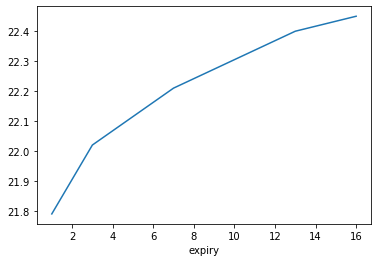

In [439]:
curve2.iloc[200].dropna().plot()

In [440]:
### INTERPOLATION & EXTRAPOLATION ###


# Function to curve fit to the data (3rd order polynomial)
def func(x, b, c, d):
    #return a * (x ** 3) + b * (x ** 2) + c * x + d
    return b * (x ** 2) + c * x + d

# Initial parameter guess, just to kick off the optimization
guess = (0.5, 0.5, 0.5)

# Create copy of data to remove NaNs for curve fitting
fit_df = curve2

# Place to store function parameters for each row
row_params = {}



In [441]:
# Curve fit each column
k = 0
a = 0

for index, row in fit_df.iterrows():
    # Get x & y
    x = list(fit_df.columns.astype(int).values)
    y = np.array(row.values)
    z = np.argwhere(np.isnan(y))

    for i in sorted(z, reverse=True):
        #print(i[0])
        del x[i[0]]

    y = y[~np.isnan(y)]
    #print(x)
    #print(y)
    #print(z)
    # Curve fit column and get curve parameters
    params = curve_fit(func, x, y, guess)
    #print(params[0])

    for i in z:
        res = func(i[0]+1, *params[0])
        #print(res)
        #print(a)
        fit_df.iloc[a,i[0]] = res
    a += 1
    
    # Store optimized parameters
    row_params[k] = params[0]
    k += 1

[2, 5, 10, 14]
[26.72 27.87 28.45 26.75]
[[ 0]
 [ 2]
 [ 3]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [10]
 [11]
 [12]
 [14]
 [15]
 [16]
 [17]
 [18]]
[-0.04929459  0.80084818 25.24611244]
25.99766601884754
0
27.205005614073116
0
27.660791628433294
0
28.27659609064842
0
28.436614538503374
0
28.498043797523252
0
28.460883867708056
0
28.090796441572436
0
27.757868945252017
0
27.32635226009652
0
26.167551323280307
0
25.440267071619587
0
24.61439363112379
0
23.68993100179292
0
22.66687918362698
0
[1, 4, 9, 13]
[28.33 29.88 31.3  29.57]
[[ 1]
 [ 2]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 9]
 [10]
 [11]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]]
[-0.05913739  0.9494935  27.30833975]
28.970777189817998
1
29.62458373539578
1
30.577372475609593
1
30.876354670245618
1
31.057062081234395
1
31.11949470857592
1
30.889535612317214
1
30.597143888716985
1
30.1864773814695
1
29.010320016032786
1
28.244829157843547
1
27.361063516007057
1
26.35902309052332
1
25.238707881392326
1
24.00011788861408
1
[1, 5, 9, 13]
[24.25 26.   27.   27.05]
[[ 

c:\Users\tatuh\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


26.440410651310728
48
26.017901828715267
48
25.29388514598197
48
24.992377285844135
48
24.731203079858844
48
24.510362528026093
48
24.189682386818212
48
24.089842797443087
48
24.030336862220505
48
24.032325954232963
48
24.093820981468003
48
24.195649662855587
48
24.33781199839571
48
24.52030798808838
48
[1, 4, 9, 13]
[27.97 25.08 24.05 23.75]
[[ 1]
 [ 2]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 9]
 [10]
 [11]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]]
[ 0.04701636 -0.98098171 28.69578441]
26.921886429309996
49
26.17598652554822
49
24.96628488933731
49
24.50248315688818
49
24.132714148209928
49
23.856977863302564
49
23.58760346480048
49
23.59396535120576
49
23.694359961381927
49
24.1772473530469
49
24.559740134535716
49
25.036265639795406
49
25.606823868825984
49
26.271414821627438
49
27.030038498199783
49
[1, 5, 9, 13]
[25.72 24.61 23.95 23.47]
[[ 1]
 [ 2]
 [ 3]
 [ 5]
 [ 6]
 [ 7]
 [ 9]
 [10]
 [11]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]]
[ 9.84375000e-03 -3.23062500e-01  2.60197188e+01]
25.412968750047792
50


In [442]:
fit_df

expiry,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Timestamp,,,,,,,,,,,,,,,,,,,
1980-10-31,25.997666,26.720000,27.205006,27.660792,27.870000,28.276596,28.436615,28.498044,28.460884,28.450000,28.090796,27.757869,27.326352,26.750000,26.167551,25.440267,24.614394,23.689931,22.666879
1980-11-30,28.330000,28.970777,29.624584,29.880000,30.577372,30.876355,31.057062,31.119495,31.300000,30.889536,30.597144,30.186477,29.570000,29.010320,28.244829,27.361064,26.359023,25.238708,24.000118
1980-12-31,24.250000,24.767188,25.241250,25.662188,26.000000,26.344688,26.606250,26.814687,27.000000,27.072187,27.121250,27.117187,27.050000,26.949687,26.786250,26.569687,26.300000,25.977187,25.601250
1981-01-31,22.320948,22.780000,23.205046,23.615352,24.004495,24.350000,24.719297,25.044954,25.370000,25.632783,25.894954,26.135963,26.355810,26.550000,26.732018,26.888379,27.023578,27.137615,27.230489
1981-02-28,24.020000,24.468111,24.875214,25.260325,25.690000,25.964572,26.283707,26.520000,26.856002,27.109162,27.340329,27.549505,27.750000,27.901881,28.045081,28.166289,28.265505,28.342729,28.397961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,72.740000,70.901947,69.712241,67.480000,67.542670,66.562804,65.652886,64.812914,64.640000,63.342811,62.712679,62.152494,61.770000,61.241965,60.891621,60.611224,60.230000,60.260269,60.189712
2022-09-30,65.350000,63.783159,62.848922,60.890000,61.144157,60.373628,59.657669,58.996279,58.389459,58.590000,57.339527,56.896415,56.360000,56.173899,55.894495,55.669661,55.499396,55.280000,55.322574
2022-10-31,74.496915,73.210000,71.398776,69.991402,68.130000,67.460045,66.336062,65.306542,64.371486,63.680000,62.784765,62.133099,61.575897,61.360000,60.744884,60.471073,60.291726,60.050000,60.216421


In [443]:
#fit_df.to_excel("sbo_interpolated.xlsx")

<AxesSubplot:xlabel='expiry'>

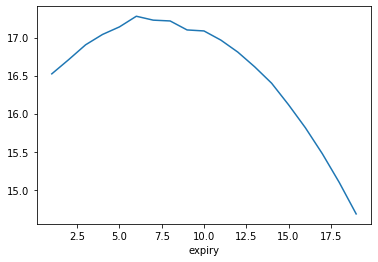

In [457]:
fit_df.iloc[75].plot()

<AxesSubplot:xlabel='expiry'>

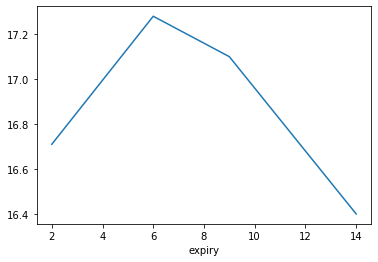

In [458]:
curve2.iloc[75].dropna().plot()

In [446]:
curve2

expiry,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Timestamp,,,,,,,,,,,,,,,,,,,
1980-10-31,25.997666,26.720000,27.205006,27.660792,27.870000,28.276596,28.436615,28.498044,28.460884,28.450000,28.090796,27.757869,27.326352,26.750000,26.167551,25.440267,24.614394,23.689931,22.666879
1980-11-30,28.330000,28.970777,29.624584,29.880000,30.577372,30.876355,31.057062,31.119495,31.300000,30.889536,30.597144,30.186477,29.570000,29.010320,28.244829,27.361064,26.359023,25.238708,24.000118
1980-12-31,24.250000,24.767188,25.241250,25.662188,26.000000,26.344688,26.606250,26.814687,27.000000,27.072187,27.121250,27.117187,27.050000,26.949687,26.786250,26.569687,26.300000,25.977187,25.601250
1981-01-31,22.320948,22.780000,23.205046,23.615352,24.004495,24.350000,24.719297,25.044954,25.370000,25.632783,25.894954,26.135963,26.355810,26.550000,26.732018,26.888379,27.023578,27.137615,27.230489
1981-02-28,24.020000,24.468111,24.875214,25.260325,25.690000,25.964572,26.283707,26.520000,26.856002,27.109162,27.340329,27.549505,27.750000,27.901881,28.045081,28.166289,28.265505,28.342729,28.397961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,72.740000,70.901947,69.712241,67.480000,67.542670,66.562804,65.652886,64.812914,64.640000,63.342811,62.712679,62.152494,61.770000,61.241965,60.891621,60.611224,60.230000,60.260269,60.189712
2022-09-30,65.350000,63.783159,62.848922,60.890000,61.144157,60.373628,59.657669,58.996279,58.389459,58.590000,57.339527,56.896415,56.360000,56.173899,55.894495,55.669661,55.499396,55.280000,55.322574
2022-10-31,74.496915,73.210000,71.398776,69.991402,68.130000,67.460045,66.336062,65.306542,64.371486,63.680000,62.784765,62.133099,61.575897,61.360000,60.744884,60.471073,60.291726,60.050000,60.216421
